## Qiskit quantum neural network (QNN) tutorial

### Create the neural network ansatz
We use the same ansatz from the QCNN tutorial: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html 

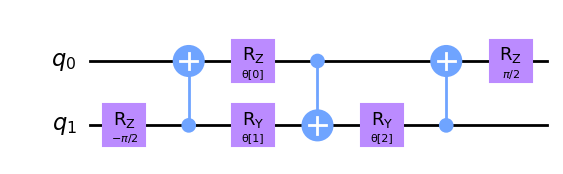

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

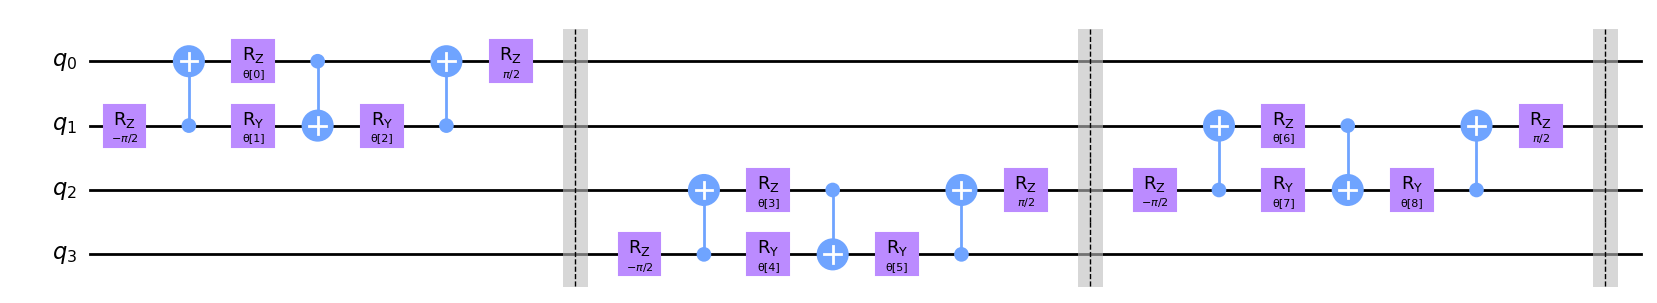

In [2]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

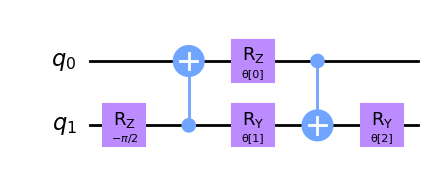

In [3]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

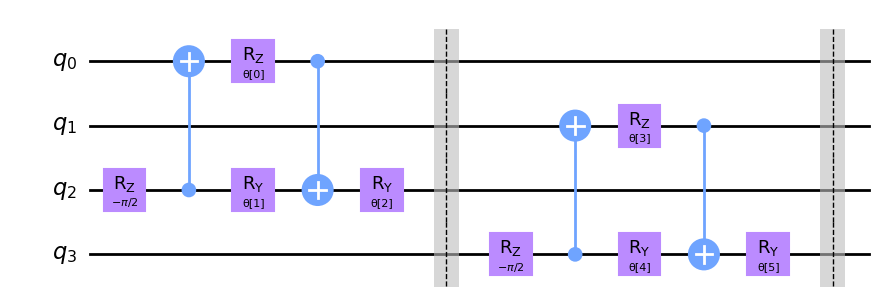

In [4]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

### Generate the data
We randomly generate a dataset consisting of images with horizontal and vertical lines. Images with horizontal lines are labeled -1 and vertical with +1.

In [5]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels

In [6]:
from sklearn.model_selection import train_test_split


np.random.seed(42)
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

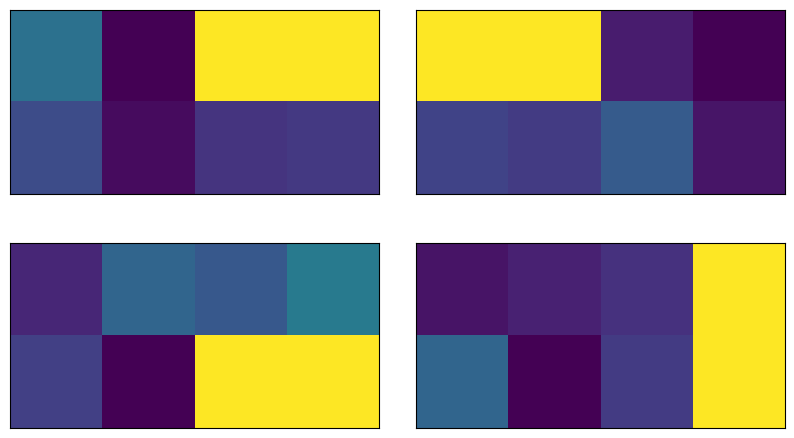

In [7]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

### Create the circuit
Now we build the circuit by combining the feature map for the data encoding and the ansatz.

In [8]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp


feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")
# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)
# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

### Load the data and do a forward pass
We write a function to do one forward pass of the quantum neural network. Then we test it with a small batch from the dataset and randomly initialized ansatz parameters.

In [9]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
from typing import Sequence


def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observables: Sequence[BaseOperator] | BaseOperator
) -> np.ndarray:
    """
    Forward pass of the neural network.
    
    circuit: circuit consisting of data loader gates and the neural network ansatz.
    input_params: data encoding parameters.
    weight_params: neural network ansatz parameters.
    estimator: EstimatorV2 primitive. 
    observables: a single oberservable or a sequence of observables to compute the expectation over.

    output: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
    Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    parameters = np.concatenate((input_params, weights), axis=1)
    job = estimator.run(
        [circuit] * num_samples * len(observables),
        [op for op in observables for _ in range(num_samples)],
        np.tile(parameters, (len(observables), 1)),
    )
    results = job.result()
    results_postprocessed = np.squeeze(np.reshape(results.values, (-1, num_samples)))
    
    return results_postprocessed

Example forward pass with two images from the dataset and randomly initialized ansatz parameters.

In [10]:
from qiskit.primitives import Estimator


np.random.seed(42)

result = forward(circuit=circuit, 
                 input_params=np.array(train_images[:2]), 
                 weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi, 
                 estimator=Estimator(), 
                 observables=observable)
print(result)

[0.07978917 0.08644573]


### TODO: Gradient with parameter shift rule
We will implement one example gradient function to be used with gradient-based optimizers. For now, we skip the two cells below and use a gradient-free optimizer such as COBYLA.

In [11]:
def param_shift_estimator_gradient(circuit: QuantumCircuit,
                                   input_params: np.ndarray, 
                                   weight_params: np.ndarray, 
                                   estimator: BaseEstimatorV2,
                                   observable: BaseOperator
) -> np.ndarray:
    """
    Compute the gradients of the expectation values by the parameter shift rule [1].

    **Reference:**
    [1] Schuld, M., Bergholm, V., Gogolin, C., Izaac, J., and Killoran, N. Evaluating analytic
    gradients on quantum hardware, `DOI <https://doi.org/10.1103/PhysRevA.99.032331>`_
    """
    num_samples = input_params.shape[0]
    num_input_params = input_params.shape[1]
    num_weight_params = len(weight_params)

    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    parameters = np.concatenate((input_params, weights), axis=1)
    job = estimator.run(
        [circuit] * num_samples * len(observables),
        [op for op in observables for _ in range(num_samples)],
        np.tile(parameters, (len(observables), 1)),
    )
    results = job.result()
    results_postprocessed = np.reshape(results.values, (-1, num_samples)).T
    
    return results_postprocessed

In [12]:
np.random.seed(12345)

input_params = np.array([train_images[0], train_images[1]])
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
estimator = Estimator()
observables = [observable, observable]

result = param_shift_estimator_gradient(circuit, input_params, weight_params, estimator, observables)
print(result)

[[ 0.04742064  0.04742064]
 [-0.0034983  -0.0034983 ]]


### Loss function
For this example, we implement the L2 loss averaged over samples, i.e. mean squared error.

In [13]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Compute the L2 loss averaged over samples, i.e. mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        return (np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2).mean()

Example run of the loss function.

In [14]:
batch_size = 2
train_images_batch = np.array(train_images[:batch_size])
train_labels_batch = np.array(train_labels[:batch_size])
print(f"True labels: {train_labels_batch}")

np.random.seed(42)

pred_batch = forward(circuit=circuit, 
                     input_params=train_images_batch, 
                     weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi,
                     estimator=Estimator(),
                     observables=observable)
print(f"Predictions: {pred_batch}")

loss = mse_loss(predict=pred_batch, target=train_labels_batch)
print(f"Loss: {loss}")

True labels: [-1 -1]
Predictions: [0.07978917 0.08644573]
Loss: 1.1731544776258447


### Cost function
This function only takes the ansatz parameters as input for the optimizer. Other variables for the forward pass and the loss are set as global parameters.

In [15]:
def cost_function(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observables=observables)
    
    cost = mse_loss(predict=predictions, 
                    target=target)
    objective_func_vals.append(cost)
    
    global iter
    if iter % 100 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

Initial variables for the cost function.

In [16]:
# Globals
circuit = circuit
input_params = train_images_batch
estimator = Estimator()
observables = observable
target = train_labels_batch
objective_func_vals = []
iter = 0

Example run of the cost function.

In [17]:
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
cost_function(weight_params)

Iter: 0, loss: 1.1731544776258447


1.1731544776258447

### Optimizer
Now we run the optimizer once for a small batch from the training data.

In [18]:
from scipy.optimize import minimize


res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 1000})
print(res)

Iter: 100, loss: 0.419191200295916
Iter: 200, loss: 0.1210127109249009
Iter: 300, loss: 0.016477788534458155
Iter: 400, loss: 0.0041763633061791886
Iter: 500, loss: 0.0005187786834729747
Iter: 600, loss: 0.00019164172164419085
Iter: 700, loss: 0.00010657617186487183
Iter: 800, loss: 4.344938690331934e-05
Iter: 900, loss: 2.2697278495114143e-05
Iter: 1000, loss: 1.424630144221436e-05
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 1.388883880743974e-05
       x: [ 3.258e+00  6.291e+00 ...  7.068e+00  6.297e+00]
    nfev: 1000
   maxcv: 0.0


### Accuracy

In [19]:
print(res['x'])
pred_batch = forward(circuit, train_images_batch, res['x'], estimator, observable)
print(pred_batch)

[ 3.25781442  6.29053583  4.73310038  4.71075689  1.62520958  1.55689686
  1.55021362  5.14947455  4.47193921  5.20440214  0.06322513  6.27154856
  5.30421014  0.45910933  2.3785671   1.45950861  1.76785349  3.13817986
  4.3784623   1.59957188  5.38253349  0.24486476  2.55677772  2.6574856
  2.50843841  4.8603683   2.88951011  3.1808831   3.20352453 -0.0148651
  4.51918455  2.01602702  1.62867336  6.14727316  5.72007353  4.75565497
  1.51995688  0.42683685  4.71329265  2.90669672  0.74039113  3.26483105
  0.1825645   5.61185104  1.83424964  3.9903557   1.59081807  4.61984579
  3.36223958  1.37582381  7.32295537  5.1582975   7.06844166  6.29719406]
[-0.99713068 -0.99557906]


Cutoff at 0 for classification.

In [20]:
import copy


pred_labels_batch = copy.deepcopy(pred_batch)
pred_labels_batch[pred_labels_batch >= 0] = 1
pred_labels_batch[pred_labels_batch < 0] = -1

print(f"Predicted labels: {pred_labels_batch}")
print(f"True labels: {train_labels_batch}")

Predicted labels: [-1. -1.]
True labels: [-1 -1]


Accuracy over the batch of training samples.

In [31]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(train_labels_batch, pred_labels_batch)
print(f"Accuracy: {accuracy * 100}%")


ValueError: Found input variables with inconsistent numbers of samples: [5, 2]

### Loop over the dataset in batches and epochs

In [28]:
batch_size = 10
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit
estimator = Estimator()
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 500})
        weight_params = res['x']



Epoch: 0, batch: 0
Iter: 0, loss: 1.006562073278484
Iter: 100, loss: 0.9018875365550206
Iter: 200, loss: 0.7940823903454863
Iter: 300, loss: 0.7551138984200596
Iter: 400, loss: 0.7304731574494737
Epoch: 0, batch: 1
Iter: 500, loss: 1.0004782941726278
Iter: 600, loss: 0.7783820645636765
Iter: 700, loss: 0.5553996368551957
Iter: 800, loss: 0.5214316848121481
Iter: 900, loss: 0.5007795981265784
Epoch: 0, batch: 2
Iter: 1000, loss: 0.7190690765916146
Iter: 1100, loss: 0.7156275201359502
Iter: 1200, loss: 0.6389493189083233
Iter: 1300, loss: 0.614195785512775
Iter: 1400, loss: 0.5673751199395374
Epoch: 0, batch: 3
Iter: 1500, loss: 0.5687637320783854
Iter: 1600, loss: 0.4366323821997429
Iter: 1700, loss: 0.35385616284366017
Iter: 1800, loss: 0.2853701865447439
Iter: 1900, loss: 0.2503315519681736


In [33]:
from sklearn.metrics import accuracy_score


pred_test = forward(circuit, np.array(test_images), res['x'], estimator, observable)
print(pred_test)

pred_labels_test = copy.deepcopy(pred_test)
pred_labels_test[pred_labels_test >= 0] = 1
pred_labels_test[pred_labels_test < 0] = -1
print(pred_labels_test)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_labels_test)
print(f"Accuracy: {accuracy * 100}%")

[0.54908125 0.65143716 0.6325099  0.62274088 0.60737252 0.47493019
 0.57959308 0.78591051 0.57006302 0.57513981 0.61932934 0.76911401
 0.67813772 0.57088095 0.65189179]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
Accuracy: 73.33333333333333%


In [34]:
from sklearn.metrics import accuracy_score


pred_test = forward(circuit, np.array(train_images), res['x'], estimator, observable)
print(pred_test)

pred_labels_test = copy.deepcopy(pred_test)
pred_labels_test[pred_labels_test >= 0] = 1
pred_labels_test[pred_labels_test < 0] = -1
print(pred_labels_test)
print(test_labels)

accuracy = accuracy_score(train_labels, pred_labels_test)
print(f"Accuracy: {accuracy * 100}%")

[ 0.67457043  0.75592673  0.30902574  0.6368099   0.60891259  0.53456263
  0.72176354  0.53399081  0.65963     0.64615683  0.74611215  0.61013411
 -0.16329902  0.65959174  0.58232673  0.70570878  0.44819186  0.49303689
  0.28020647  0.16399772  0.58557619  0.54167195  0.2162433   0.62442153
  0.63388556  0.47893639  0.22787604  0.57839827  0.55050321  0.53241119
  0.51643081 -0.22794097  0.76876764  0.65790148  0.56270862]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.]
[-1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
Accuracy: 68.57142857142857%
